# EECS 442 FINAL: Geoguessr Neural Network

## Setup

In [1]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import math
import torch.nn as nn
import torchvision.models as models

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
Mount the cwd to drive, access the train folder and load the images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install gitpython > /dev/null 2>&1
# !apt-get install -y -qq git > /dev/null 2>&1

import os
import glob
import random
from PIL import Image


# print(os.getcwd())
# ! ls
# ! cd drive/MyDrive/442final
# print(os.getcwd())

data_directory = "/drive/MyDrive/442final/train/resized_countries_reshape"

batch_size = 32
img_width = 148
img_height = 64
epochs = 30

img_target_scale = 0.2
img_target_width = int(math.floor(img_width * img_target_scale))
img_target_height= int(math.floor(img_height * img_target_scale))

class get_Images(Dataset):
  def __init__(self, root_dir, split='train', percentage=0.7, transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """
    self.files = []
    self.labels = []

    # if split=='val':
    #   percentage = 1 - percentage

    self.transform = transform
    print(root_dir)
    for idx, country in enumerate(os.listdir(root_dir)):
      print(idx, end=' ')
      # Check if the item is a directory
      files_in_dir = np.load(root_dir+'/'+country).astype(np.float32)
      # print(files_in_dir.dtype)
      # Randomly sample a certain percentage of files
      num_files_to_take = int(len(files_in_dir) * percentage)
      # Append the sampled file paths to the list
      if split=='train':
        self.files.extend(files_in_dir[:num_files_to_take])
      else:
        num_files = len(files_in_dir)
        self.files.extend(files_in_dir[num_files - num_files_to_take:])

      # self.files.extend(glob.glob(os.path.join(root_dir, country, '*.jpg')))
      self.labels.extend([idx] * num_files_to_take)
    print()
    print(len(self.files))
    print(len(self.labels))
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # img_path = self.files[idx]
    label = self.labels[idx]
    # img = Image.open(img_path)
    # if self.transform:
    #     img = self.transform(img)
    return {'image': self.files[idx], 'label': label}

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should be named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = get_Images(os.getcwd() + data_directory, split='train', percentage=0.5,  transform=transform)
te_dt = get_Images(os.getcwd() + data_directory, split='val', percentage=0.2, transform=transform)

train_loader = DataLoader(tr_dt, batch_size=4, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=5, shuffle=False)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

print("Done!")

Mounted at /content/drive
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
17975
17975
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
7171
7171
Number of training images 17975, number of testing images 7171
Done!


## Model
CHANGE THIS TO GET THE MODEL TO RUN

In [11]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################
        # TODO: Design your own network, define layers here.                          #
        # Here We provide a sample of two-layer fc network from HW4 Part3.           #
        # Your solution, however, should contain convolutional layers.               #
        # Refer to PyTorch documentations of torch.nn to pick your layers.           #
        # (https://pytorch.org/docs/stable/nn.html)                                  #
        # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
        # If you have many layers, use nn.Sequential() to simplify your code         #
        ##############################################################################
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(),
            # nn.AvgPool2d(kernel_size=5, stride=3),
            nn.Conv2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=20, stride=3),
            nn.Flatten(),
            nn.Linear(2352 , 128),  # Adjust the input size according to your desired dimensions
            nn.ReLU(),
            nn.Linear(128, 55)
          )
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        # TODO: Design your own network, implement forward pass here                 #
        ##############################################################################
        x = self.conv_relu_stack(x)
        return x
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

# model = Network().to(device)
alexnet = models.alexnet(pretrained=True)

print(alexnet)

# Freeze all layers except the last three
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the last three layers to be trainable
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, 55)  # Change the output size to 55 classes

# Print the modified AlexNet architecture
print(alexnet)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
# print('Your network:')
# print(summary(model, (3,148,64), device=device)) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate, weight_decay, num_epoch = 0.001, 0.0001, 10
optimizer = optim.Adam(alexnet.parameters(), learning_rate)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:06<00:00, 37.8MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [12]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        # print(len(tqdm(trainloader)))
        # for i in tqdm(trainloader):
        #   print(i)
        for input in tqdm(trainloader):
            # print(batch, label)
            # print(batch)
            batch, label = input['image'], input['label']
            # print(batch)
            # print(label)
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for input in tqdm(loader):
            batch, label = input['image'], input['label']
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader,
                                                  test_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
# evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 4494/4494 [00:09<00:00, 474.34it/s]



 Epoch 1 loss:3.081918734574668


100%|██████████| 4494/4494 [00:04<00:00, 1104.81it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1011.58it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 2-----------------


100%|██████████| 4494/4494 [00:09<00:00, 467.76it/s]



 Epoch 2 loss:3.081823125859606


100%|██████████| 4494/4494 [00:03<00:00, 1135.57it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1047.85it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 3-----------------


100%|██████████| 4494/4494 [00:10<00:00, 422.78it/s]



 Epoch 3 loss:3.081855758328304


100%|██████████| 4494/4494 [00:04<00:00, 1050.45it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 948.53it/s] 



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 4-----------------


100%|██████████| 4494/4494 [00:09<00:00, 470.55it/s]



 Epoch 4 loss:3.0818783488069896


100%|██████████| 4494/4494 [00:06<00:00, 674.86it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 957.76it/s] 



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 5-----------------


100%|██████████| 4494/4494 [00:09<00:00, 498.67it/s]



 Epoch 5 loss:3.081874860834428


100%|██████████| 4494/4494 [00:04<00:00, 958.55it/s] 



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1010.74it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 6-----------------


100%|██████████| 4494/4494 [00:09<00:00, 481.34it/s]



 Epoch 6 loss:3.081861820521225


100%|██████████| 4494/4494 [00:04<00:00, 1045.57it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1032.31it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 7-----------------


100%|██████████| 4494/4494 [00:09<00:00, 471.13it/s]



 Epoch 7 loss:3.081851447058297


100%|██████████| 4494/4494 [00:03<00:00, 1144.86it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1032.38it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 8-----------------


100%|██████████| 4494/4494 [00:09<00:00, 466.17it/s]



 Epoch 8 loss:3.081858671104107


100%|██████████| 4494/4494 [00:03<00:00, 1132.15it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 1061.01it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 9-----------------


100%|██████████| 4494/4494 [00:09<00:00, 471.05it/s]



 Epoch 9 loss:3.0819053789430795


100%|██████████| 4494/4494 [00:04<00:00, 1119.99it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 951.91it/s]



 Evaluation accuracy: 0.1684562822479431
-----------------Epoch = 10-----------------


100%|██████████| 4494/4494 [00:09<00:00, 461.87it/s]



 Epoch 10 loss:3.0818562983511604


100%|██████████| 4494/4494 [00:04<00:00, 1061.79it/s]



 Evaluation accuracy: 0.1904867872044506

 Evaluate on validation set...


100%|██████████| 1435/1435 [00:01<00:00, 821.52it/s]


 Evaluation accuracy: 0.1684562822479431
Done!

 Evaluate on test set
CPU times: user 2min 25s, sys: 2.68 s, total: 2min 28s
Wall time: 2min 35s


Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

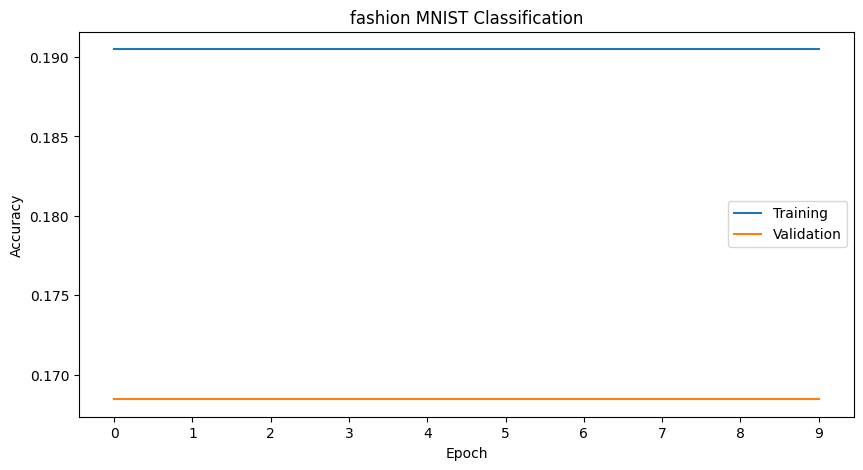

In [13]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()